<a href="https://colab.research.google.com/github/solobala/FEML23/blob/master/FEML23_DZ6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание «Деревья решений» обновленное


**Преподаватель**: Юлия Пономарева, Егор Шишковец

**Задание**

**Цель**: изучить применение дерева решений в рамках задачи регрессии

**Описание задания**:
В домашнем задании нужно решить задачу регрессии. В качестве датасета необходимо взять данные о недвижимости Калифорнии из библиотеки sklearn.datasets. Целевая переменная – MedHouseVal. Прочитать информацию о признаках датасета можно, выполнив следующий код – print(fetch_california_housing().DESCR). На полученных данных построить модель регрессии и дерево решений.

In [ ]:
## https://github.com/ZakharovOleg/Machine-learning-projects/blob/master/MLA_regression.py

### 0. Установка пакетов,  импорт библиотек и пользовательские функции

In [ ]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from numpy import mean, std

from sklearn.model_selection import train_test_split,KFold, cross_validate,GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
import graphviz
from sklearn import tree


from datetime import datetime
from IPython.display import display

from scipy.stats import chi2
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
def mahalanobis(x= None , data= None , cov= None ):
  """
  Функция для расчета расстояния Maхаланобиса
  Расстояние Махаланобиса — это расстояние между двумя точками в 
  многомерном пространстве. Оно часто используется для поиска выбросов 
  в статистическом анализе, включающем несколько переменных
  https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9C%D0%B0%D1%85%D0%B0%D0%BB%D0%B0%D0%BD%D0%BE%D0%B1%D0%B8%D1%81%D0%B0
  """
  x_mu = x - np.mean(data)
  if not cov:
    cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
  return mahal.diagonal()

In [ ]:
def my_score(model, X_train, X_test, y_train, y_test, print_on_off):
  """
  Рассчитывает train_score и test_score с помощью встроенной ф-ии score 
  для обучающего и тестового   подмножеств.
  Рассчитывает разницу в процентах.
  Параметр print_on_off позволяет включить-выключить печать
  """
  predictions_train = model.predict(X_train)
  predictions_test = model.predict(X_test)
  train_score = model.score(X_train,y_train)
  test_score = model.score(X_test,y_test)
  diff = (train_score-test_score)/train_score *100
  if print_on_off:
    print(f'train: score = {train_score}, test: score = {test_score}')
    print(f'Разница в метриках {diff} %')
  return train_score, test_score, diff

In [ ]:
def get_diff(X, y,  leaf_sample, leaf_nodes, max_depth,cv,scoring, random_state, print_on_off):  
  """
  Функция выполняет обучение DecisionTreeRegressor с заданным параметром Max_depth, 
  перебирая  max_leaf_nodes из заданного диапазона leaf_nodes. 
  Выполняет кросс-валидацию, определяет средние значения R2 для train и test 
  и вычисляет разницу в %.
  Возврашает 3 массива r2_train, r2_test, diffs
  """
  r2_train, r2_test, diffs,dt_regs ={}, {}, {},{}
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state) 
 
  for i in leaf_nodes:
  
      dt_regs[f'depth={max_depth} max_leaf_nodes={i}'] = DecisionTreeRegressor(max_depth=max_depth, \
                                                                               max_leaf_nodes=i, \
                                                                               min_samples_leaf=leaf_sample, \
                                                                               random_state=random_state).fit(X_train, y_train)
      scores = cross_validate(dt_regs[f'depth={max_depth} max_leaf_nodes={i}'], \
                            X, y, scoring=scoring, cv=cv, return_train_score=True)
      train_R2 = scores['train_R2'].mean()
      test_R2 = scores['test_R2'].mean()
      dif = (train_R2 - test_R2)/train_R2*100
      r2_train[f'depth={max_depth} max_leaf_nodes={i}'] = train_R2
      r2_test[f'depth={max_depth} max_leaf_nodes={i}'] = test_R2
      diffs[f'depth={max_depth} max_leaf_nodes={i}'] = dif
      
      
      if print_on_off:
        print(f"leaf_nodes = {i},{train_R2}, {test_R2}, {dif} ")
        
  return r2_train, r2_test, diffs  

     

## 1. Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую).


In [ ]:
from sklearn.datasets import fetch_california_housing 
dataset = fetch_california_housing(as_frame=True)
X, y = dataset.data, dataset.target
feature_names = dataset.feature_names
data=pd.DataFrame.from_dict(X ) # Только X
df=pd.concat([data,y],axis=1) # X и y
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 2. Проведите первичный анализ.

In [ ]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


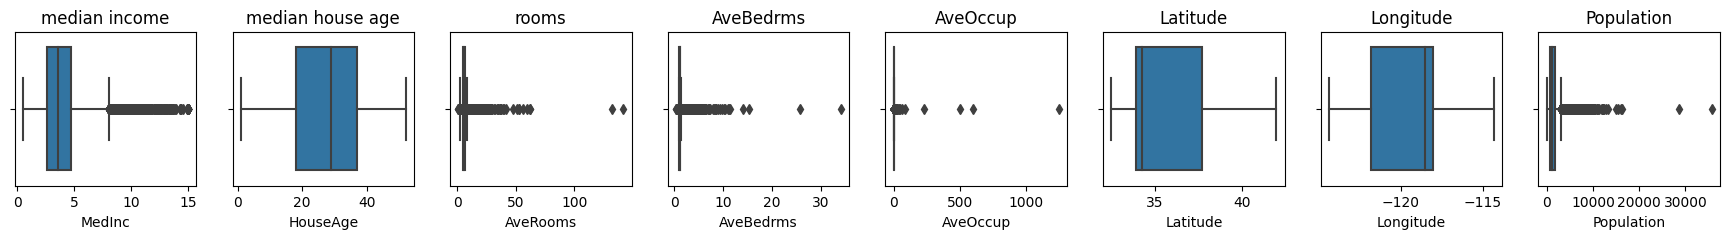

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=8, figsize=(22,2))

_ = sns.boxplot(x=X['MedInc'],  ax=ax[0])
ax[0].set_title('median income')
_ = sns.boxplot(x=X['HouseAge'],  ax=ax[1])
ax[1].set_title('median house age')
_ = sns.boxplot(x=X['AveRooms'], ax=ax[2])
ax[2].set_title('rooms')
_ = sns.boxplot(x=X['AveBedrms'], ax=ax[3])
ax[3].set_title('AveBedrms')
_ = sns.boxplot(x=X['AveOccup'], ax=ax[4])
ax[4].set_title( 'AveOccup')
_ = sns.boxplot(x=X['Latitude'], ax=ax[5])
ax[5].set_title( 'Latitude')
_ = sns.boxplot(x=X['Longitude'], ax=ax[6])
ax[6].set_title( 'Longitude')
_ = sns.boxplot(x=X['Population'], ax=ax[7])
ax[7].set_title( 'Population')
plt.show()
plt.close()

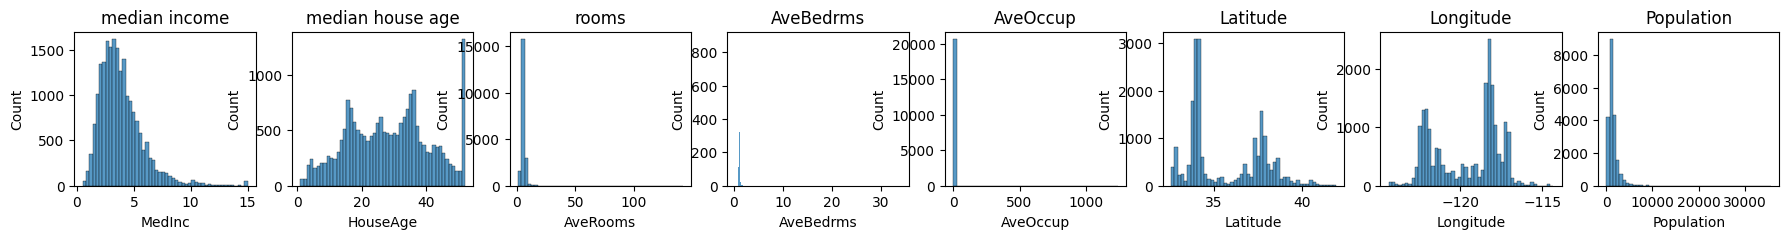

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=8, figsize=(22,2))

_ = sns.histplot(x=X['MedInc'], bins=50, ax=ax[0])
ax[0].set_title('median income')
_ = sns.histplot(x=X['HouseAge'], bins=50, ax=ax[1])
ax[1].set_title('median house age')
_ = sns.histplot(x=X['AveRooms'], bins=50,ax=ax[2])
ax[2].set_title('rooms')
_ = sns.histplot(x=X['AveBedrms'], ax=ax[3])
ax[3].set_title('AveBedrms')
_ = sns.histplot(x=X['AveOccup'], bins=50,ax=ax[4])
ax[4].set_title( 'AveOccup')
_ = sns.histplot(x=X['Latitude'], bins=50,ax=ax[5])
ax[5].set_title( 'Latitude')
_ = sns.histplot(x=X['Longitude'], bins=50,ax=ax[6])
ax[6].set_title( 'Longitude')
_ = sns.histplot(x=X['Population'], bins=50,ax=ax[7])
ax[7].set_title( 'Population')
plt.show()
plt.close()

### a.Проверьте данные на пропуски. Удалите в случае обнаружения.

In [ ]:
df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

### b.*Нормализуйте один из признаков.

In [ ]:
df['Population'] = df['Population']/df['Population'].max() # Нормализуем population

In [ ]:
df['mahalanobis'] = mahalanobis(x=df, data=df[list(df.columns)])
df['p'] = 1 - chi2.cdf(df['mahalanobis'], 3)

#Обычно выбросом считается p-значение меньше 0,001
tmp=df[df['p']>0.001]

df=tmp.drop(columns=['mahalanobis', 'p'])
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,0.009024,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,0.067289,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,0.013901,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,0.015638,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,0.015834,2.181467,37.85,-122.25,3.422


## 3. Разделите выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.


In [ ]:
y=df['MedHouseVal']
X=df.drop('MedHouseVal', axis=1)
random_seed = 42


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed) 

## 4. Обучите модель регрессии на обучающем множестве.


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
 

LinearRegression()

## 5. Для тестового множества предскажите целевую переменную и сравните с истинным значением, посчитав точность предсказания модели. Для этого используйте встроенную функцию score.

In [ ]:
train_scores={}
test_scores={}
differences={}
cv = KFold(7, shuffle=True, random_state=random_seed)
scoring = {'R2': 'r2',
           'RMSE': 'neg_root_mean_squared_error'}

In [ ]:
train_score, test_score, diff_lr = my_score(model, X_train, X_test, y_train, y_test, print_on_off=True)


train: score = 0.6826421424336134, test: score = 0.7007710535509354
Разница в метриках -2.6556976181828653 %


Получились подозрительно высокие значения метрик качества модели (по сравнению с предыдущим дз, где схожие результаты на том же датасете были достигнуты после большого количества "танцев  с бубнами". Вызывает сомнения и полученная отрицательная разница в метриках -  score на тесте оказалась лучше, чем на обучающей выборке. Похоже, что результаты стоит перепроверить  с помощью кросс-валидации

In [ ]:
scores=cross_validate(model, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
scores

{'fit_time': array([0.04830933, 0.03501654, 0.0405786 , 0.03148913, 0.02627015,
        0.02982473, 0.03580356]),
 'score_time': array([0.01350069, 0.00559711, 0.01032758, 0.00320196, 0.00329685,
        0.0032866 , 0.02477598]),
 'test_R2': array([0.69499412, 0.70005389, 0.68430166, 0.67885013, 0.66691363,
        0.68017936, 0.69220505]),
 'train_R2': array([0.68481229, 0.68388519, 0.68665074, 0.68746563, 0.68928902,
        0.68732839, 0.68534639]),
 'test_RMSE': array([-0.60598347, -0.60081695, -0.62010495, -0.60352033, -0.62243806,
        -0.61208159, -0.60059441]),
 'train_RMSE': array([-0.60921084, -0.61011404, -0.60682152, -0.60959224, -0.60660807,
        -0.60815442, -0.61006815])}

In [ ]:
print(f'Результаты кросс-валидации: {model}')
print("________________________________________________________________________________")
print(f"Средние значения по обучающей выборке: R2={scores['train_R2'].mean()}, RMSE={scores['train_RMSE'].mean()}") 
print(f"Средние значения по тестовой выборке: R2={scores['test_R2'].mean()}, RMSE={scores['test_RMSE'].mean()}") 
print(f"Различия в средних значениях R2_train и R2_test: {(scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100} %")
print(f"Размах значений R2 после кросс-валидации на тесте: {(max( scores['test_R2'])- min( scores['test_R2']))/max( scores['test_R2'])*100} %")

Результаты кросс-валидации: LinearRegression()
________________________________________________________________________________
Средние значения по обучающей выборке: R2=0.6863968061011061, RMSE=-0.6086527528014406
Средние значения по тестовой выборке: R2=0.6853568331811919, RMSE=-0.6093628214852634
Различия в средних значениях R2_train и R2_test: 0.15151191128372074 %
Размах значений R2 после кросс-валидации на тесте: 4.7339584223185875 %


В принципе, неплохо! Учитывая минимальную предварительную подготовку датасета

In [ ]:
train_scores['LinearRegression']=scores['train_R2'].mean()
test_scores['LinearRegression']=scores['test_R2'].mean()
differences['LinearRegression']=(scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100

## 6. Обучите дерево решений на обучающем множестве.


In [ ]:
dt_regs_base = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

### a. Повторите п. 5 для полученной модели.


In [ ]:
r2_train_base, r2_test_base, diffs_base = my_score(dt_regs_base, X_train, X_test, y_train, y_test, print_on_off=True)

train: score = 1.0, test: score = 0.6369613109986152
Разница в метриках 36.30386890013848 %


Модель переобучена! Подтвердим это с помощью кросс-валидации

In [ ]:
scores=cross_validate(dt_regs_base, X, y, scoring=scoring, 
                         cv=cv, return_train_score=True)
scores

{'fit_time': array([0.52011037, 0.48689699, 0.39723015, 0.38572025, 0.3187778 ,
        0.51739621, 0.71543312]),
 'score_time': array([0.00537539, 0.0053432 , 0.00520849, 0.00531006, 0.00536799,
        0.02044582, 0.02839994]),
 'test_R2': array([0.64773647, 0.64044082, 0.64920146, 0.64246462, 0.62371772,
        0.65490917, 0.63197124]),
 'train_R2': array([1., 1., 1., 1., 1., 1., 1.]),
 'test_RMSE': array([-0.65123917, -0.657818  , -0.65366907, -0.63679192, -0.66156816,
        -0.6358033 , -0.6567369 ]),
 'train_RMSE': array([-1.98203626e-16, -1.93746629e-16, -2.57804641e-16, -2.06834205e-16,
        -2.68316897e-16, -2.42887611e-16, -2.07973796e-16])}

In [ ]:
print(f'Результаты кросс-валидации: {dt_regs_base}')
print("________________________________________________________________________________")
print(f"Средние значения по обучающей выборке: R2={scores['train_R2'].mean()}, RMSE={scores['train_RMSE'].mean()}") 
print(f"Средние значения по тестовой выборке: R2={scores['test_R2'].mean()}, RMSE={scores['test_RMSE'].mean()}") 
print(f"Различия в средних значениях R2_train и R2_test: {(scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100} %")
print(f"Размах значений R2 после кросс-валидации на тесте: {(max( scores['test_R2'])- min( scores['test_R2']))/max( scores['test_R2'])*100} %")

Результаты кросс-валидации: DecisionTreeRegressor(random_state=42)
________________________________________________________________________________
Средние значения по обучающей выборке: R2=1.0, RMSE=-2.2510962929402653e-16
Средние значения по тестовой выборке: R2=0.641491641589609, RMSE=-0.6505180724941165
Различия в средних значениях R2_train и R2_test: 35.8508358410391 %
Размах значений R2 после кросс-валидации на тесте: 4.762714847188775 %


После кросс-валидации R2 для train по прежнему 1 

In [ ]:
train_scores['DecisionTreeBase'] = scores['train_R2'].mean()
test_scores['DecisionTreeBase'] = scores['test_R2'].mean()
differences['DecisionTreeBase'] = (scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100

###b. Визуализируйте часть дерева решений. Убедитесь, что график получился читабельным. Посмотрите примеры визуализации по ссылке.

Определяем значимость фич с помощью встроенного в DecisionTreeRegressor метода feature_importances_

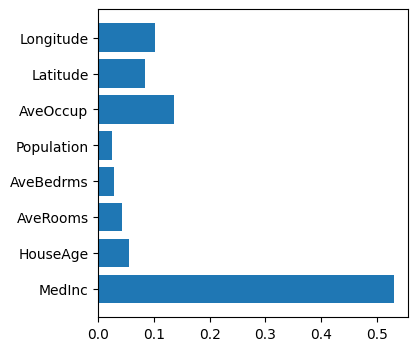

In [ ]:
a4_dims = (4, 4)
fig, ax = plt.subplots(figsize=a4_dims)
plt.barh(np.arange(len(dt_regs_base.feature_importances_)), dt_regs_base.feature_importances_)
plt.yticks(np.arange(len(dataset.data.columns)), dataset.data.columns)
plt.show()

Для визуализации части дерева берем часть датасета (первые 10 строк) и самые важные фичи - MedInc и AveOccup

In [ ]:
Xcut = X_train.loc[:, ['MedInc', 'AveOccup']].head(10)
ycut=y_train.head(10)

In [ ]:
tdr = DecisionTreeRegressor(random_state=random_seed,).fit(Xcut, ycut)

### Визуализация при помощи plot_tree

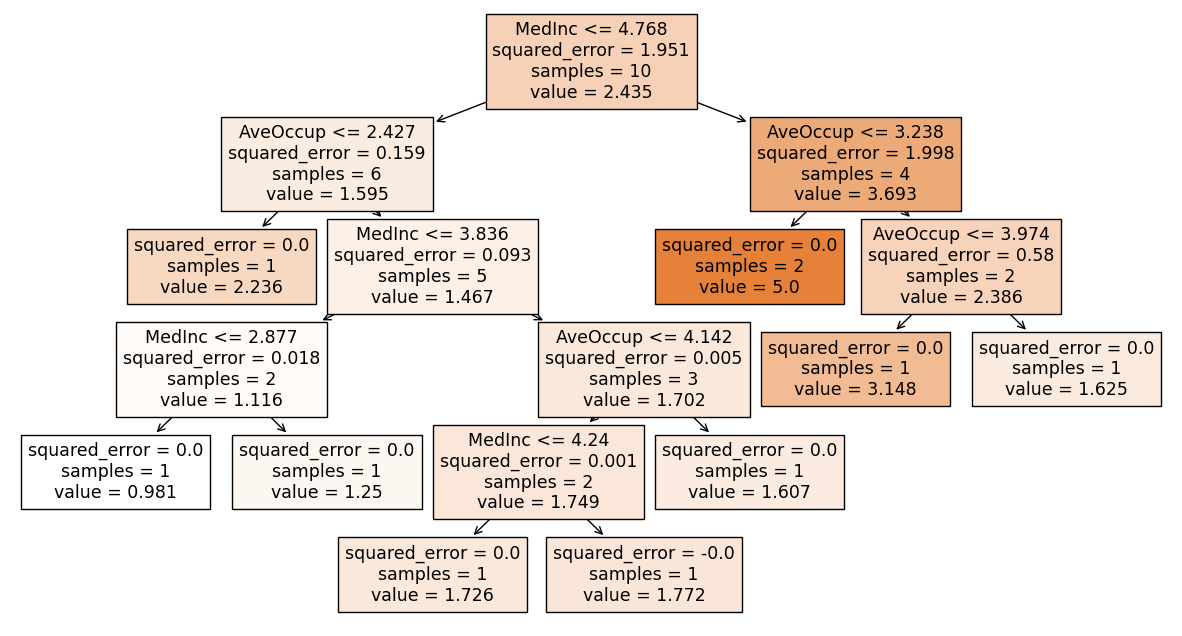

In [ ]:
plt.figure(figsize=(15, 8))
plot_tree(tdr, feature_names=Xcut.columns, filled=True);

### Визуализация при помощи graphviz

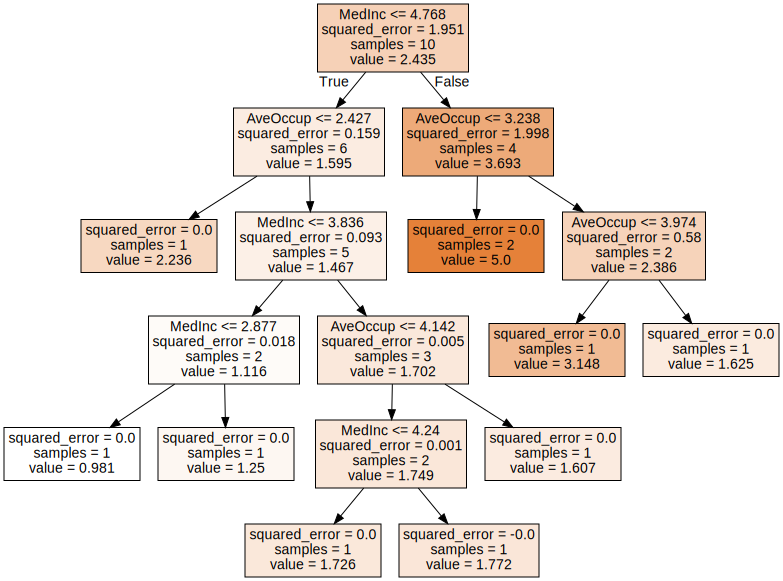

In [ ]:
dot_data = tree.export_graphviz(tdr, out_file=None, feature_names=Xcut.columns, filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

##7. Оптимизируйте глубину дерева (max_depth). 

In [ ]:
r2_train, r2_test, differ, dt_regs_tree_opt1 ={}, {}, {}, {}
list_depth = [1,2,3,4,5,6,7]
# устанавливаем базовые значения метрик( средние значения после кросс-валидации) и гиперпараметра max_depth

r2_train_best = scores['train_R2'].mean()
r2_test_best =   scores['test_R2'].mean() 
dif = (r2_train_best - r2_test_best)/r2_train_best*100
print(f"Базовые значения: {r2_train_best}, {r2_test_best}, {dif}")

max_depth_opt = 0
for i in list_depth:
  # Результаты расчета метрик зависят от разбиения. Для одного дерева фигня получается. Нужно несколько разбиений делать
  dt_regs_tree_opt1[i] = DecisionTreeRegressor(max_depth=i, random_state=random_seed).fit(X_train, y_train)
  scores=cross_validate(dt_regs_tree_opt1[i], X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
  
  r2_train[i] = scores['train_R2'].mean()
  r2_test[i] = scores['test_R2'].mean()
  differ[i] = (r2_train[i]-r2_test[i])/r2_train[i]*100 
  print(f"max_depth={i} r2_train={r2_train[i]} r2_test={r2_test[i]} differ={differ[i]}")   
  # Условие оптимизациии - метрики растут, разница между ними не больше чем в линейной регрессии 
  if (differ[i] < dif) &  (r2_train[i] < r2_train_best) & (r2_test[i] > r2_test_best):
    r2_train_best = r2_train[i]
    r2_test_best = r2_test[i]
    # dif = diffs[i]
    max_depth_opt = i
print('_______________________________')
print(f'Оптимальная глубина дерева = {max_depth_opt}') 
   

Базовые значения: 1.0, 0.641491641589609, 35.8508358410391
max_depth=1 r2_train=0.3184644498873537 r2_test=0.3076450266007798 differ=3.397372388158517
max_depth=2 r2_train=0.4586843091672823 r2_test=0.4495205568513846 differ=1.9978342691804831
max_depth=3 r2_train=0.5484281151330006 r2_test=0.5351906625642375 differ=2.4137078686333995
max_depth=4 r2_train=0.6019066997522718 r2_test=0.5872371072388207 differ=2.4371871121369346
max_depth=5 r2_train=0.6496140331447664 r2_test=0.6291580677609068 differ=3.1489414236993585
max_depth=6 r2_train=0.68831120924989 r2_test=0.6579795375300931 differ=4.406679901792074
max_depth=7 r2_train=0.7282701467577566 r2_test=0.6849109908920326 differ=5.9537186933664765
_______________________________
Оптимальная глубина дерева = 6


Наименьшая разница в train и test получилась при max_depth=2. Но там очень плохие метрики качества. Более приемлемой выглядит max_depth=6 (разница train и test 4,06 % незначительна)

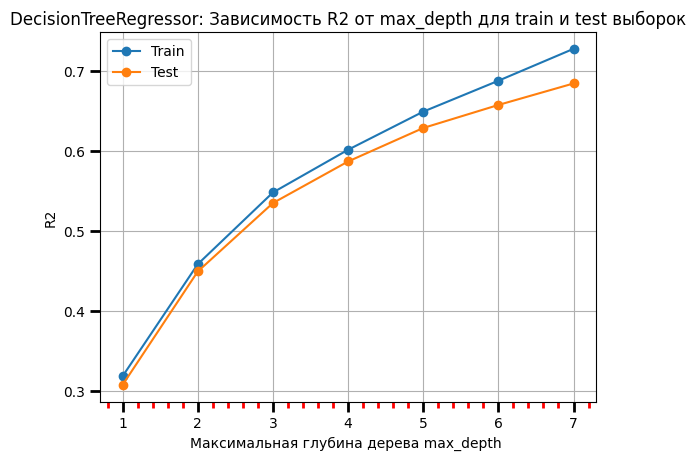

In [ ]:
figure, ax = plt.subplots(1,1)
ax.set_xlabel(f'Максимальная глубина дерева max_depth ')
ax.set_ylabel('R2')
ax.set_title('DecisionTreeRegressor: Зависимость R2 от max_depth для train и test выборок')
line1, = ax.plot(list_depth, r2_train.values(), '-o', label='Train')
line2, = ax.plot(list_depth, r2_test.values(), '-o', label='Test')
ax.legend(handles=[line1, line2])
ax.grid(True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='r')
plt.show()

### a. Повторите п. 5 для полученной модели.

In [ ]:
dt_regs_tree_opt1[max_depth_opt].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
r2_train_regs_tree_opt1, r2_test_regs_tree_opt1, diffs_regs_tree_opt1 = my_score(dt_regs_tree_opt1[max_depth_opt], X_train, X_test, y_train, y_test, print_on_off=True)

train: score = 0.6876388305284767, test: score = 0.666664342089673
Разница в метриках 3.0502187351293246 %


In [ ]:
scores=cross_validate(dt_regs_tree_opt1[max_depth_opt], X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
scores

{'fit_time': array([0.15456843, 0.10723138, 0.10797167, 0.11440206, 0.11508226,
        0.10806894, 0.11969209]),
 'score_time': array([0.00455117, 0.00444269, 0.00436831, 0.00375295, 0.00471044,
        0.00397563, 0.0040648 ]),
 'test_R2': array([0.67234957, 0.65192391, 0.66473543, 0.64491774, 0.66164133,
        0.64376831, 0.66652047]),
 'train_R2': array([0.68612413, 0.6851999 , 0.70413408, 0.69239927, 0.68529843,
        0.68413761, 0.68088506]),
 'test_RMSE': array([-0.62807578, -0.64722853, -0.6390324 , -0.63460358, -0.62734489,
        -0.64598487, -0.62515128]),
 'train_RMSE': array([-0.60794172, -0.60884399, -0.58964974, -0.60476162, -0.6104911 ,
        -0.61124962, -0.61437786])}

In [ ]:
print(f'Результаты кросс-валидации: {dt_regs_tree_opt1[max_depth_opt]}')
print("________________________________________________________________________________")
print(f"Средние значения по обучающей выборке: R2={scores['train_R2'].mean()}, RMSE={scores['train_RMSE'].mean()}") 
print(f"Средние значения по тестовой выборке: R2={scores['test_R2'].mean()}, RMSE={scores['test_RMSE'].mean()}") 
print(f"Различия в средних значениях R2_train и R2_test: {(scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100} %")
print(f"Размах значений R2 после кросс-валидации на тесте: {(max( scores['test_R2'])- min( scores['test_R2']))/max( scores['test_R2'])*100} %")

Результаты кросс-валидации: DecisionTreeRegressor(max_depth=6, random_state=42)
________________________________________________________________________________
Средние значения по обучающей выборке: R2=0.68831120924989, RMSE=-0.6067593792992255
Средние значения по тестовой выборке: R2=0.6579795375300931, RMSE=-0.6353459029163603
Различия в средних значениях R2_train и R2_test: 4.406679901792074 %
Размах значений R2 после кросс-валидации на тесте: 4.250951650854423 %


In [ ]:
train_scores[f"DecisionTree max_depth={max_depth_opt}"] = scores['train_R2'].mean()
test_scores[f"DecisionTree max_depth={max_depth_opt}"] = scores['test_R2'].mean()
differences[f"DecisionTree max_depth={max_depth_opt}"] = (scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100

Из графика кривых обучения видно, что начиная с глубины дерева =2 при прочих равых условиях рост метрики качества R2_test замедляется по сравнению с R2_train, что свидетельствует о отм, что модель переобучена. После оптимизации по max_depth переобученность в значительной степени уменьшилась (с 36,3% до 4,4%)

## *Оптимизируйте ещё один параметр модели на выбор.

самые популярные параметры для оптимизации:
*    max_depth - Максимальная глубина дерева ( по умолчанию none), 
*    min_samples_leaf - Минимальное количество обьъектов конечного узла ( по умолчанию 1) и 
*    max_leaf_nodes - максимальное к-во листовых узлов (по умолчанию none)

max_depth уже попробовали, возьмем max_leaf_nodes и будем изменять его в интервале от 40 до 2 при заданной max_depth

In [ ]:
# max_depth_opt=6. Границы изменения leaf_nodes были предварительно определены
leaf_nodes=np.arange(65,10,-1)
r2_train_ln, r2_test_ln, diffs_ln = get_diff(X, y,  leaf_sample=1, \
                                             leaf_nodes=leaf_nodes, \
                                             max_depth=max_depth_opt, cv=cv, \
                                             scoring=scoring, \
                                             random_state=random_seed, \
                                             print_on_off=True)
      

leaf_nodes = 65,0.6883112092498901, 0.6579795375300931, 4.4066799017920895 
leaf_nodes = 64,0.6883112092498901, 0.6579795375300931, 4.4066799017920895 
leaf_nodes = 63,0.6882267140150022, 0.6581271487347052, 4.373495632667476 
leaf_nodes = 62,0.6880675338350987, 0.6581233246906113, 4.351928796521848 
leaf_nodes = 61,0.6878418807854901, 0.6581648889051441, 4.3145078410253195 
leaf_nodes = 60,0.6875679503496313, 0.6582259296273296, 4.2675084996880805 
leaf_nodes = 59,0.6872459350361181, 0.6585600312216943, 4.174037611865429 
leaf_nodes = 58,0.6868392049971248, 0.6584721227048957, 4.130090723686603 
leaf_nodes = 57,0.6864266791328281, 0.658416950446797, 4.0805128264268635 
leaf_nodes = 56,0.6859671026496923, 0.6577946314280239, 4.106971181685877 
leaf_nodes = 55,0.6854178127545332, 0.6576506667704091, 4.0511269866965485 
leaf_nodes = 54,0.6847965851204805, 0.6571065531903046, 4.04354118169327 
leaf_nodes = 53,0.6841986877255932, 0.6571324521669808, 3.955902875023884 
leaf_nodes = 52,0.683

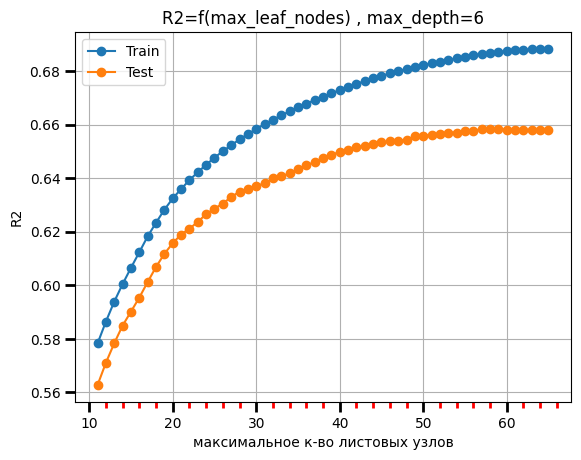

In [ ]:
figure, ax = plt.subplots(1,1)
ax.set_xlabel(f'максимальное к-во листовых узлов')
ax.set_ylabel('R2')
ax.set_title(f'R2=f(max_leaf_nodes) , max_depth={max_depth_opt}')
line1, = ax.plot(leaf_nodes, r2_train_ln.values(), '-o', label='Train')
line2, = ax.plot(leaf_nodes, r2_test_ln.values(), '-o', label='Test')
ax.legend(handles=[line1, line2])
ax.grid(True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='r')
plt.show()

Визуально сложно определить, при каком значении max_leaf_nodes началось переобучение модели. Выглядит, что при max_leaf_nodes=18. Однако в этом случае метрики качества хуже, чем до оптимизации, поэтому ищем компромисс: метрики не должны ухудшаться, а вот разница между train и Test должна уменьшиться. R2 на тесте перестает расти после 59 узлов

In [ ]:
# Стартовые значения берем из предыдущей модели оптимизации по глубине дерева
r2_train_opt2, r2_test_opt2, differ_opt2, dt_regs_tree_opt2 ={}, {}, {}, {}
r2_train_best = r2_train[max_depth_opt] 
r2_test_best =  r2_test[max_depth_opt]
dif_opt = differ[max_depth_opt] 
max_leaf_nodes_opt = None
min_samples_leaf_opt = 1
print(f"Базовые значения: {r2_train_best}, {r2_test_best}, {dif_opt}, {max_leaf_nodes_opt}, {min_samples_leaf_opt}")
# Если найденная разница меньше эталона dif_opt, а  scores_train_mean>= эталону и 
# scores_test_mean>= эталону, меняем эталоны  r2_train_best и r2_test_best и 
# запоминаем значения max_leaf_nodes_opt=i, min_samples_leaf_opt=j
for i, element in enumerate(zip(r2_train_ln.values(), r2_test_ln.values(), diffs_ln.values())): 
  r2_train[i] = element[0]
  r2_test[i] = element[1]
  differ[i] = element[2]
  # Если метрики улучшились, а разница снизилась - все отлично
  if  (r2_test[i] > r2_test_best) & \
      (differ[i] < dif_opt) :

      r2_train_best = r2_train[i]
      r2_test_best = r2_test[i]
      dif_opt = differ[i]
      max_leaf_nodes_opt = 65-i
 
  #Если ничего не изменилось, идем дальше
  elif ( r2_train[i] == r2_train_best) & \
      ( r2_test[i] == r2_test_best) & \
      (differ[i] == dif_opt) :

      max_leaf_nodes_opt = 65-i
      break
  else:
    pass   
print(f'При max_depth = {max_depth_opt}, max_leaf_nodes = {max_leaf_nodes_opt}, R2_train = {r2_train_best}, R2_test = {r2_test_best}  при разнице в train и test ={dif_opt}%') 

Базовые значения: 0.68831120924989, 0.6579795375300931, 4.406679901792074, None, 1
При max_depth = 6, max_leaf_nodes = 59, R2_train = 0.6872459350361181, R2_test = 0.6585600312216943  при разнице в train и test =4.174037611865429%


Переобучение убрали. Метрика качества на тестовой выборке (0.6585600312216943)   лучше, чем у линейной регрессии (0.6853568331811919),и лучше, чем после 1 оптимизации (0.6579795375300931), а разница между train и test - меньше. 

Выполним расчеты для DecisionTreeRegressor с оптимальными гиперпараметрами max_depth=6 и max_leaf_nodes=59

In [ ]:
dt_regs_tree_opt2 =  DecisionTreeRegressor(max_depth=max_depth_opt, \
                                           max_leaf_nodes=max_leaf_nodes_opt, \
                                           min_samples_leaf=1, \
                                           random_state=random_seed).fit(X_train, y_train)

In [ ]:
dt_regs_tree_opt2.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 59,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
r2_train_regs_tree_opt2, r2_test_regs_tree_opt2, diffs_regs_tree_opt2 = my_score(dt_regs_tree_opt2, X_train, X_test, y_train, y_test, print_on_off=True)

train: score = 0.6867369319620433, test: score = 0.6660018771687677
Разница в метриках 3.0193592084867937 %


In [ ]:
scores=cross_validate(dt_regs_tree_opt2, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
scores

{'fit_time': array([0.16930509, 0.11636567, 0.12909627, 0.10710526, 0.11908269,
        0.11375284, 0.07664275]),
 'score_time': array([0.00453854, 0.00444961, 0.00426197, 0.00399184, 0.0042572 ,
        0.00281644, 0.00252819]),
 'test_R2': array([0.67248958, 0.65169935, 0.6658812 , 0.6467207 , 0.66191927,
        0.64473631, 0.66647381]),
 'train_R2': array([0.68499968, 0.68425805, 0.70313174, 0.6911954 , 0.68441732,
        0.68335514, 0.6793642 ]),
 'test_RMSE': array([-0.62794157, -0.64743728, -0.63793951, -0.6329904 , -0.62708717,
        -0.6451066 , -0.62519502]),
 'train_RMSE': array([-0.60902971, -0.60975411, -0.59064771, -0.6059439 , -0.61134513,
        -0.61200625, -0.61584014])}

In [ ]:
print(f'Результаты кросс-валидации: {dt_regs_tree_opt2}')
print("________________________________________________________________________________")
print(f"Средние значения по обучающей выборке: R2={scores['train_R2'].mean()}, RMSE={scores['train_RMSE'].mean()}") 
print(f"Средние значения по тестовой выборке: R2={scores['test_R2'].mean()}, RMSE={scores['test_RMSE'].mean()}") 
print(f"Различия в средних значениях R2_train и R2_test: {(scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100} %")
print(f"Размах значений R2 после кросс-валидации на тесте: {(max( scores['test_R2'])- min( scores['test_R2']))/max( scores['test_R2'])*100} %")

Результаты кросс-валидации: DecisionTreeRegressor(max_depth=6, max_leaf_nodes=59, random_state=42)
________________________________________________________________________________
Средние значения по обучающей выборке: R2=0.6872459350361181, RMSE=-0.6077952786739477
Средние значения по тестовой выборке: R2=0.6585600312216943, RMSE=-0.6348139348564805
Различия в средних значениях R2_train и R2_test: 4.174037611865429 %
Размах значений R2 после кросс-валидации на тесте: 4.126945018459366 %


In [ ]:
train_scores[f"DecisionTree max_depth={max_depth_opt} max_leaf_nodes={max_leaf_nodes_opt}"] = scores['train_R2'].mean()
test_scores[f"DecisionTree max_depth={max_depth_opt} max_leaf_nodes={max_leaf_nodes_opt}"] = scores['test_R2'].mean()
differences[f"DecisionTree max_depth={max_depth_opt} max_leaf_nodes={max_leaf_nodes_opt}"] = (scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100

Построим зависимость средней после кросс-валидации величины R2_test  от max_leaf_nodes для различных значений max_depth

In [ ]:
leaf_nodes=np.arange(65,1,-1)
r_test_exp=[]
diff_exp=[]
for i in range(3,8):
  a, b, c = get_diff(X, y,  leaf_sample=1, \
                      leaf_nodes=leaf_nodes, \
                      max_depth=i, cv=cv, \
                      scoring=scoring, \
                      random_state=random_seed, \
                      print_on_off=False)
  diff_exp.append(c)
  r_test_exp.append(b)

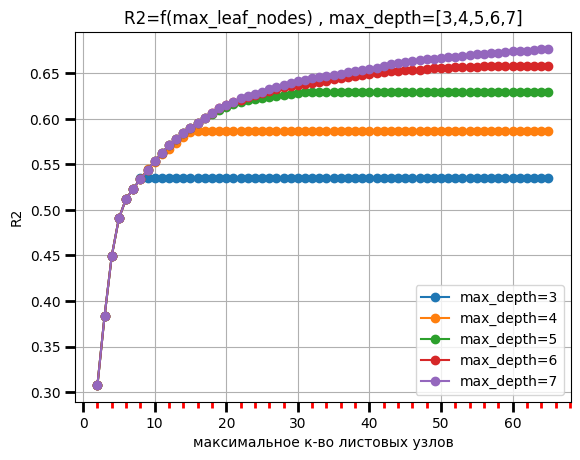

In [ ]:
figure, ax = plt.subplots(1,1)
ax.set_xlabel(f'максимальное к-во листовых узлов')
ax.set_ylabel('R2')
ax.set_title(f'R2=f(max_leaf_nodes) , max_depth=[3,4,5,6,7]')
line3, = ax.plot(leaf_nodes, r_test_exp[0].values(), '-o', label='max_depth=3')
line4, = ax.plot(leaf_nodes, r_test_exp[1].values(), '-o', label='max_depth=4')
line5, = ax.plot(leaf_nodes, r_test_exp[2].values(), '-o', label='max_depth=5')
line6, = ax.plot(leaf_nodes, r_test_exp[3].values(), '-o', label='max_depth=6')
line7, = ax.plot(leaf_nodes, r_test_exp[4].values(), '-o', label='max_depth=7')
ax.legend(handles=[line3, line4, line5, line6, line7])
ax.grid(True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='r')
plt.show()

Метрики качества растут с увеличением глубины дерева. Однако мы уже знаем, что для ликвидации переобучения нужно откатиться на max_depth=6. Метрика на красной линии перестает расти на 59 узле.

Построим зависимость  diff от max_leaf_nodes при разных значениях max_depth

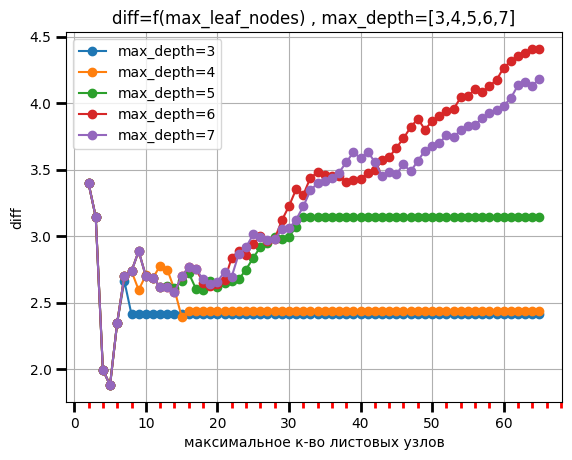

In [ ]:
figure, ax = plt.subplots(1,1)
ax.set_xlabel(f'максимальное к-во листовых узлов')
ax.set_ylabel('diff')
ax.set_title(f'diff=f(max_leaf_nodes) , max_depth=[3,4,5,6,7]')

line3, = ax.plot(leaf_nodes, diff_exp[0].values(), '-o', label='max_depth=3')
line4, = ax.plot(leaf_nodes, diff_exp[1].values(), '-o', label='max_depth=4')
line5, = ax.plot(leaf_nodes, diff_exp[2].values(), '-o', label='max_depth=5')
line6, = ax.plot(leaf_nodes, diff_exp[3].values(), '-o', label='max_depth=6')
line7, = ax.plot(leaf_nodes, diff_exp[4].values(), '-o', label='max_depth=7')
ax.legend(handles=[line3, line4, line5, line6, line7])
ax.grid(True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='r')
plt.show()

На графике видно, что минимальные расхождения между train и test достигаются для всех max_depth в max_leaf_nodes=5. Далее картина меняется: для 3 локальный минимум-7 узлов, для 4  - в 15, для 5 в 18, для 6 и 7 - в 19. Однако здесь мы ничего не знаем о величине r2_train. 

Используем инструментарий scikit-learn 

Оптимизируем глубину max_depth

In [ ]:
parameters={ "max_depth" : [_ for _ in range (3,50)]}
tuning_model_0=GridSearchCV(dt_regs_base,param_grid=parameters,scoring='neg_mean_squared_error',cv=cv,verbose=0)
tuning_model_0.fit(X,y)
tuning_model_0.best_params_

{'max_depth': 10}

In [ ]:
tuned_hyper_model_0= DecisionTreeRegressor(max_depth=tuning_model_0.best_params_['max_depth']).fit(X_train, y_train)
r2_train_regs_tree__tuned_0, r2_test_regs_tree__tuned_0, diffs_regs_tree__tuned_0 = my_score(tuned_hyper_model_0, X_train, X_test, y_train, y_test, print_on_off=True)

! Переобучение!

Оптимизируем max_leaf_nodes

In [ ]:
parameters={ "max_leaf_nodes" : [_ for _ in range (2,100)]}
tuning_model_01=GridSearchCV(dt_regs_base,param_grid=parameters,scoring='neg_mean_squared_error',cv=cv,verbose=0)
tuning_model_01.fit(X,y)
tuning_model_01.best_params_

{'max_leaf_nodes': 98}

In [ ]:
tuned_hyper_model_01= DecisionTreeRegressor(max_leaf_nodes=tuning_model_01.best_params_['max_leaf_nodes']).fit(X_train, y_train)
r2_train_regs_tree__tuned_01, r2_test_regs_tree__tuned_01, diffs_regs_tree__tuned_01 = my_score(tuned_hyper_model_01, X_train, X_test, y_train, y_test, print_on_off=True)

train: score = 0.7493917350551353, test: score = 0.7112603410779031
Разница в метриках 5.088312586530827 %


In [ ]:
scores=cross_validate(tuned_hyper_model_01, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
scores

{'fit_time': array([0.10875487, 0.09786344, 0.0986681 , 0.09924459, 0.10670066,
        0.09931636, 0.09985638]),
 'score_time': array([0.00271153, 0.00289917, 0.00292444, 0.00299096, 0.00267339,
        0.0026319 , 0.00265121]),
 'test_R2': array([0.70173558, 0.69793141, 0.71121219, 0.70354435, 0.70021472,
        0.70047368, 0.70974009]),
 'train_R2': array([0.73790887, 0.74035524, 0.75539426, 0.74874101, 0.73558619,
        0.74269579, 0.73260303]),
 'test_RMSE': array([-0.5992491 , -0.60293896, -0.5930871 , -0.57985298, -0.59050403,
        -0.59234342, -0.58323565]),
 'train_RMSE': array([-0.55553208, -0.55294047, -0.53614216, -0.54657699, -0.55959258,
        -0.55168743, -0.56239342])}

In [ ]:
print(f'Результаты кросс-валидации: {tuned_hyper_model_01}')
print("________________________________________________________________________________")
print(f"Средние значения по обучающей выборке: R2={scores['train_R2'].mean()}, RMSE={scores['train_RMSE'].mean()}") 
print(f"Средние значения по тестовой выборке: R2={scores['test_R2'].mean()}, RMSE={scores['test_RMSE'].mean()}") 
print(f"Различия в средних значениях R2_train и R2_test: {(scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100} %")
print(f"Размах значений R2 после кросс-валидации на тесте: {(max( scores['test_R2'])- min( scores['test_R2']))/max( scores['test_R2'])*100} %")

Результаты кросс-валидации: DecisionTreeRegressor(max_leaf_nodes=98)
________________________________________________________________________________
Средние значения по обучающей выборке: R2=0.7418977682126402, RMSE=-0.552123591138295
Средние значения по тестовой выборке: R2=0.7035502877933527, RMSE=-0.5916016052246661
Различия в средних значениях R2_train и R2_test: 5.1688362012023825 %
Размах значений R2 после кросс-валидации на тесте: 1.867343919881586 %


In [ ]:
train_scores[f"{tuned_hyper_model_01}"] = scores['train_R2'].mean()
test_scores[f"{tuned_hyper_model_01} "] = scores['test_R2'].mean()
differences[f"{tuned_hyper_model_01} "] = (scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100

Результаты Линейной регрессии перекрыты, но вышло хуже, чем в прерыдущем варианте. К тому же точность достигнута при условии max_depth=None ( узлы расширяются до тех пор, пока все листья не станут чистыми или пока все листья не будут содержать выборок меньше, чем min_samples_split=2)

Выполним поиск по сетке из 4 гиперпараметров с помощью GridSearchCV https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/

In [ ]:
parameters={
            "max_depth" : [6,7,8,9,10],
            "min_samples_leaf":[2,3],
            "max_leaf_nodes":[_ for _ in range(98,2,-1)], 
            "min_weight_fraction_leaf":[0.0,0.1, 0.2] 
            }

In [ ]:
tuning_model=GridSearchCV(dt_regs_base,param_grid=parameters,scoring='neg_mean_squared_error',cv=cv,verbose=0)

In [ ]:
tuning_model.fit(X,y)

GridSearchCV(cv=KFold(n_splits=7, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [6, 7, 8, 9, 10],
                         'max_leaf_nodes': [98, 97, 96, 95, 94, 93, 92, 91, 90,
                                            89, 88, 87, 86, 85, 84, 83, 82, 81,
                                            80, 79, 78, 77, 76, 75, 74, 73, 72,
                                            71, 70, 69, ...],
                         'min_samples_leaf': [2, 3],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.2]},
             scoring='neg_mean_squared_error')

In [ ]:
#  Лучшие гиперпараметры
tuning_model.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 98,
 'min_samples_leaf': 2,
 'min_weight_fraction_leaf': 0.0}

In [ ]:
# Лучшая neg_mean_squared_error
tuning_model.best_score_

-0.3516841837843218

In [ ]:
# сюда прописываем найденные гиперпараметры ( считает более 20 минут)
tuned_hyper_model= DecisionTreeRegressor(max_depth=tuning_model.best_params_['max_depth'],max_leaf_nodes=tuning_model.best_params_['max_leaf_nodes'],min_samples_leaf=1,min_weight_fraction_leaf=0.0).fit(X_train, y_train)
r2_train_regs_tree_tuned, r2_test_regs_tree__tuned, diffs_regs_tree__tuned = my_score(tuned_hyper_model, X_train, X_test, y_train, y_test, print_on_off=True)

train: score = 0.7491912976327649, test: score = 0.712043155653306
Разница в метриках 4.958432124990863 %


In [ ]:
scores=cross_validate(tuned_hyper_model, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
scores

{'fit_time': array([0.101969  , 0.10975838, 0.09737468, 0.10077929, 0.10999966,
        0.10633278, 0.11142421]),
 'score_time': array([0.00430679, 0.00270271, 0.00263762, 0.00275159, 0.0028038 ,
        0.00311828, 0.00302982]),
 'test_R2': array([0.70108902, 0.69716034, 0.70906349, 0.70211452, 0.69872335,
        0.69726121, 0.70974009]),
 'train_R2': array([0.73812228, 0.73963098, 0.75490134, 0.74799667, 0.73541395,
        0.74228468, 0.73260303]),
 'test_RMSE': array([-0.59989827, -0.603708  , -0.59528941, -0.58124963, -0.59197102,
        -0.59551144, -0.58323565]),
 'train_RMSE': array([-0.55530586, -0.55371112, -0.5366821 , -0.54738599, -0.55977481,
        -0.55212798, -0.56239342])}

In [ ]:
print(f'Результаты кросс-валидации: {tuned_hyper_model}')
print("________________________________________________________________________________")
print(f"Средние значения по обучающей выборке: R2={scores['train_R2'].mean()}, RMSE={scores['train_RMSE'].mean()}") 
print(f"Средние значения по тестовой выборке: R2={scores['test_R2'].mean()}, RMSE={scores['test_RMSE'].mean()}") 
print(f"Различия в средних значениях R2_train и R2_test: {(scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100} %")
print(f"Размах значений R2 после кросс-валидации на тесте: {(max( scores['test_R2'])- min( scores['test_R2']))/max( scores['test_R2'])*100} %")

Результаты кросс-валидации: DecisionTreeRegressor(max_depth=10, max_leaf_nodes=98)
________________________________________________________________________________
Средние значения по обучающей выборке: R2=0.7415647042450154, RMSE=-0.5524830407161764
Средние значения по тестовой выборке: R2=0.7021645751624918, RMSE=-0.592980488794859
Различия в средних значениях R2_train и R2_test: 5.313107387255816 %
Размах значений R2 после кросс-валидации на тесте: 1.7724440018309602 %


In [ ]:
train_scores[f"DecisionTree tuned"] = scores['train_R2'].mean()
test_scores[f"DecisionTree tuned"] = scores['test_R2'].mean()
differences[f"DecisionTree tuned"] = (scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100

Попробуeм выполнить оптимизацию по другому набору гиперпараметров - max_features и max_depth

In [ ]:
parameters={'max_features': [None, 'log2', 'sqrt'], 
                              'max_depth': [2,3, 4,5, 6, 7, 8, 10, 20, 50]}

In [ ]:
tuning_model2 = GridSearchCV(dt_regs_base,param_grid=parameters,scoring='neg_mean_squared_error',cv=cv,verbose=0)
tuning_model2.fit(X, y)
tuning_model2.best_score_

-0.33000627780627634

In [ ]:
tuning_model2.best_params_

{'max_depth': 10, 'max_features': 'log2'}

In [ ]:
tuned_hyper_model2= DecisionTreeRegressor(max_depth=tuning_model2.best_params_['max_depth'],max_features=tuning_model2.best_params_['max_features']).fit(X_train, y_train)
r2_train_regs_tree_tuned2, r2_test_regs_tree__tuned2, diffs_regs_tree__tuned2 = my_score(tuned_hyper_model2, X_train, X_test, y_train, y_test, print_on_off=True)

train: score = 0.8048520525918306, test: score = 0.7112710555523922
Разница в метриках 11.627105470885422 %


In [ ]:
scores=cross_validate(tuned_hyper_model2, X, y, scoring=scoring,
                         cv=cv, return_train_score=True)
scores

{'fit_time': array([0.06956959, 0.04812431, 0.04953885, 0.05034375, 0.04975128,
        0.04674292, 0.04547644]),
 'score_time': array([0.00379682, 0.00282788, 0.00281405, 0.00289345, 0.00282192,
        0.00307751, 0.00267363]),
 'test_R2': array([0.73056006, 0.72903899, 0.6954847 , 0.65633688, 0.71235639,
        0.6849    , 0.71208017]),
 'train_R2': array([0.81513034, 0.84115944, 0.80361441, 0.80628541, 0.80871653,
        0.79117989, 0.81799569]),
 'test_RMSE': array([-0.56955761, -0.57104977, -0.60902287, -0.62431604, -0.57842236,
        -0.60754755, -0.58087987]),
 'train_RMSE': array([-0.46656893, -0.43248326, -0.48039828, -0.47992315, -0.47595796,
        -0.49699933, -0.46398381])}

In [ ]:
print(f'Результаты кросс-валидации: {tuned_hyper_model2}')
print("________________________________________________________________________________")
print(f"Средние значения по обучающей выборке: R2={scores['train_R2'].mean()}, RMSE={scores['train_RMSE'].mean()}") 
print(f"Средние значения по тестовой выборке: R2={scores['test_R2'].mean()}, RMSE={scores['test_RMSE'].mean()}") 
print(f"Различия в средних значениях R2_train и R2_test: {(scores['train_R2'].mean()-scores['test_R2'].mean())/scores['train_R2'].mean()*100} %")
print(f"Размах значений R2 после кросс-валидации на тесте: {(max( scores['test_R2'])- min( scores['test_R2']))/max( scores['test_R2'])*100} %")

Результаты кросс-валидации: DecisionTreeRegressor(max_depth=10, max_features='log2')
________________________________________________________________________________
Средние значения по обучающей выборке: R2=0.8120116721104337, RMSE=-0.47090210350553635
Средние значения по тестовой выборке: R2=0.7029653107821318, RMSE=-0.5915422975961319
Различия в средних значениях R2_train и R2_test: 13.429161805628775 %
Размах значений R2 после кросс-валидации на тесте: 10.159764272588736 %


Вот в лучшем виде переобучение после GridSearchCV! И обобщающая способность модели снизилась тоже! Нужно аккуратнее с оптимизацией гиперпараметров!

## 8. Сформулируйте выводы по проделанной работе.


In [ ]:
train_scores, test_scores, differences

({'LinearRegression': 0.6863968061011061,
  'DecisionTreeBase': 1.0,
  'DecisionTree max_depth=6': 0.68831120924989,
  'DecisionTree max_depth=6 max_leaf_nodes=59': 0.6872459350361181,
  'DecisionTree tuned': 0.7415647042450154,
  'DecisionTreeRegressor(max_leaf_nodes=98)': 0.7418977682126402},
 {'LinearRegression': 0.6853568331811919,
  'DecisionTreeBase': 0.641491641589609,
  'DecisionTree max_depth=6': 0.6579795375300931,
  'DecisionTree max_depth=6 max_leaf_nodes=59': 0.6585600312216943,
  'DecisionTree tuned': 0.7021645751624918,
  'DecisionTreeRegressor(max_leaf_nodes=98) ': 0.7035502877933527},
 {'LinearRegression': 0.15151191128372074,
  'DecisionTreeBase': 35.8508358410391,
  'DecisionTree max_depth=6': 4.406679901792074,
  'DecisionTree max_depth=6 max_leaf_nodes=59': 4.174037611865429,
  'DecisionTree tuned': 5.313107387255816,
  'DecisionTreeRegressor(max_leaf_nodes=98) ': 5.1688362012023825})

### a. Сравните точность двух моделей.


В работе над датасетом оценивались 2 регрессора - LinearRegression и TreeDecisionRegressor. При этом предобработка признаков была выполнена в минимальном объеме (были удалены выбросы и один из признаков - Population - был подвергнут нормализации)
Обе модели, построенные на указанных регрессорах, показали удовлетворительную точность. При этом результаты, достигнутые в TreeDecisionRegressor, оказались несколько выше, чем у LinearRegression, точность модели возросла при подборе гиперпараметров.

### b. Напишите свое мнение, для каких задач предпочтительнее использовать обученные в работе модели? Какие у них есть плюсы и минусы?

Линейные методы(LinearRegression, Lasso, Ridge) обладают рядом важных достоинств: быстро обучаются, способны работать с большим количеством объектов и признаков, имеют небольшое количество параметров, легко регуляризуются. При этом у них есть и серьёзный недостаток — они могут восстанавливать только линейные зависимости между целевой переменной и признаками.Конечно, можно добавлять в выборку новые признаки,которые нелинейно зависят от исходных, но этот подход является чисто эвристическим, требует выбора типа нелинейности, а также всё равно ограничивает сложность модели сложностью признаков.

Решающие деревья (DecisionTreeRegressor) позволяют восстанавливать нелинейные зависимости произвольной сложности, имеют хорошую интерпретируемость и высокую выразительную способность.
Одним из основных преимуществ решающих деревьев является возможность
работы с пропущенными значениями (хотя в данном датасете пропусков не было).
В то же время, деревья плохо поддаются оптимизации из-за своей дискретной структуры, дерево нельзя продифференцировать по параметрам, да и число параметров может меняться в зависимости от глубины. критериев дробления  и пр. Кроме того, решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться.


